In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!pip install -q kaggle opendatasets

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from pathlib import Path
import time
from collections import defaultdict
from typing import Tuple, List, Dict, Any
import os

In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

Using device: cuda
GPU: Tesla T4
Memory: 15.64 GB


In [ ]:
import opendatasets as od

od.download('https://www.kaggle.com/datasets/muratkokludataset/rice-image-dataset')

DATA_DIR = './rice-image-dataset/Rice_Image_Dataset'

Skipping, found downloaded files in "./rice-image-dataset" (use force=True to force download)


In [ ]:
BATCH_SIZE = 32
NUM_EPOCHS = 15
LEARNING_RATE = 0.0001
IMG_SIZE = 224
NUM_WORKERS = 2
SUBSET_RATIO = 0.3

In [ ]:
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomRotation(45),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
def load_data(data_dir: str, train_split: float = 0.8) -> Tuple[DataLoader, DataLoader, List[str]]:
    full_dataset = datasets.ImageFolder(data_dir)

    train_size = int(train_split * len(full_dataset))
    val_size = len(full_dataset) - train_size

    train_dataset, val_dataset = random_split(
        full_dataset,
        [train_size, val_size],
        generator=torch.Generator().manual_seed(42)
    )

    from torch.utils.data import Subset
    subset_size = int(0.3 * len(train_dataset))
    subset_indices = list(range(subset_size))
    train_dataset = Subset(train_dataset, subset_indices)

    # Fix the transform access for nested Subset
    if hasattr(train_dataset, 'dataset'):
        if hasattr(train_dataset.dataset, 'dataset'):
            train_dataset.dataset.dataset.transform = train_transforms
        else:
            train_dataset.dataset.transform = train_transforms

    val_dataset_copy = datasets.ImageFolder(data_dir, transform=val_transforms)

    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKERS,
        pin_memory=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=True
    )

    class_names = full_dataset.classes

    print(f"Dataset loaded:")
    print(f"  Total samples: {len(full_dataset)}")
    print(f"  Train samples: {train_size}")
    print(f"  Val samples: {val_size}")
    print(f"  Number of classes: {len(class_names)}")
    print(f"  Classes: {class_names}")

    return train_loader, val_loader, class_names

In [ ]:
train_loader, val_loader, class_names = load_data(DATA_DIR)
num_classes = len(class_names)

Dataset loaded:
  Total samples: 75000
  Train samples: 60000
  Val samples: 15000
  Number of classes: 5
  Classes: ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']


In [ ]:
def create_model(num_classes: int) -> nn.Module:
    model = models.efficientnet_b0(pretrained=True)
    num_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_features, num_classes)
    return model.to(DEVICE)

In [ ]:
model = create_model(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)

In [ ]:
def train_epoch(model: nn.Module, dataloader: DataLoader, criterion: nn.Module, optimizer: optim.Optimizer, epoch: int) -> Tuple[float, float]:
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (inputs, labels) in enumerate(dataloader):
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if (batch_idx + 1) % 10 == 0:
            print(f"  Batch [{batch_idx+1}/{len(dataloader)}] Loss: {loss.item():.4f} Acc: {100*correct/total:.2f}%", end='\r')

    print()

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

In [ ]:
def validate(model: nn.Module, dataloader: DataLoader, criterion: nn.Module) -> Tuple[float, float, List[int], List[int]]:
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc, all_preds, all_labels

In [ ]:
def calculate_per_class_accuracy(labels: List[int], preds: List[int], class_names: List[str]) -> Dict[str, float]:
    class_correct = defaultdict(int)
    class_total = defaultdict(int)

    for label, pred in zip(labels, preds):
        class_total[label] += 1
        if label == pred:
            class_correct[label] += 1

    per_class_acc = {}
    for class_idx in range(len(class_names)):
        if class_total[class_idx] > 0:
            acc = 100 * class_correct[class_idx] / class_total[class_idx]
            per_class_acc[class_names[class_idx]] = acc
        else:
            per_class_acc[class_names[class_idx]] = 0.0

    return per_class_acc

In [ ]:
history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
}

best_val_acc = 0.0
patience = 5
patience_counter = 0

print("="*70)
print("STARTING TRAINING")
print("="*70)

for epoch in range(NUM_EPOCHS):
    start_time = time.time()

    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    print("-" * 70)

    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, epoch)
    val_loss, val_acc, val_preds, val_labels = validate(model, val_loader, criterion)

    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    epoch_time = time.time() - start_time

    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"  Val Loss: {val_loss:.4f}   | Val Acc: {val_acc:.2f}%")
    print(f"  Learning Rate: {current_lr:.6f}")
    print(f"  Time: {epoch_time:.2f}s")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'class_names': class_names
        }, 'best_seed_model.pth')
        print(f"  ✓ Best model saved! (Val Acc: {val_acc:.2f}%)")
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"\n  Early stopping triggered after {epoch+1} epochs")
        break

print("\n" + "="*70)
print("TRAINING COMPLETE")
print("="*70)

STARTING TRAINING

Epoch 1/15
----------------------------------------------------------------------

  Train Loss: 0.2226 | Train Acc: 92.94%
  Val Loss: 0.0473   | Val Acc: 98.36%
  Learning Rate: 0.000099
  Time: 214.11s
  ✓ Best model saved! (Val Acc: 98.36%)

Epoch 2/15
----------------------------------------------------------------------

  Train Loss: 0.0645 | Train Acc: 97.78%
  Val Loss: 0.0276   | Val Acc: 99.07%
  Learning Rate: 0.000096
  Time: 199.64s
  ✓ Best model saved! (Val Acc: 99.07%)

Epoch 3/15
----------------------------------------------------------------------

  Train Loss: 0.0480 | Train Acc: 98.49%
  Val Loss: 0.0280   | Val Acc: 99.04%
  Learning Rate: 0.000090
  Time: 196.77s

Epoch 4/15
----------------------------------------------------------------------

  Train Loss: 0.0401 | Train Acc: 98.63%
  Val Loss: 0.0285   | Val Acc: 99.05%
  Learning Rate: 0.000083
  Time: 196.69s

Epoch 5/15
------------------------------------------------------------------

KeyboardInterrupt: 

In [ ]:
checkpoint = torch.load('best_seed_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
_, _, final_preds, final_labels = validate(model, val_loader, criterion)

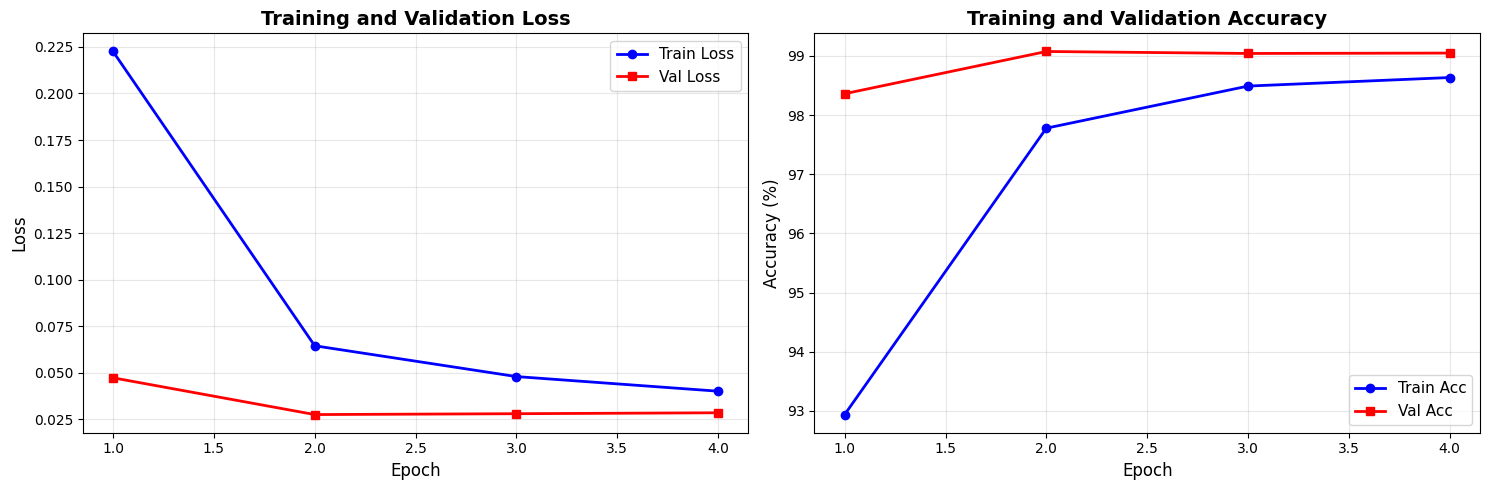

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

epochs = range(1, len(history['train_loss']) + 1)

ax1.plot(epochs, history['train_loss'], 'b-o', label='Train Loss', linewidth=2, markersize=6)
ax1.plot(epochs, history['val_loss'], 'r-s', label='Val Loss', linewidth=2, markersize=6)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

ax2.plot(epochs, history['train_acc'], 'b-o', label='Train Acc', linewidth=2, markersize=6)
ax2.plot(epochs, history['val_acc'], 'r-s', label='Val Acc', linewidth=2, markersize=6)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy (%)', fontsize=12)
ax2.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
per_class_acc = calculate_per_class_accuracy(final_labels, final_preds, class_names)

print("\n" + "="*70)
print("PER-CLASS ACCURACY")
print("="*70)
for class_name, acc in sorted(per_class_acc.items(), key=lambda x: x[1], reverse=True):
    print(f"  {class_name:30s}: {acc:6.2f}%")


PER-CLASS ACCURACY
  Ipsala                        :  99.97%
  Basmati                       :  99.12%
  Karacadag                     :  99.09%
  Arborio                       :  98.77%
  Jasmine                       :  98.42%


In [ ]:
print("\n" + "="*70)
print("CLASSIFICATION REPORT")
print("="*70)
print(classification_report(final_labels, final_preds, target_names=class_names, digits=4))


CLASSIFICATION REPORT
              precision    recall  f1-score   support

     Arborio     0.9902    0.9877    0.9890      3082
     Basmati     0.9879    0.9912    0.9896      2962
      Ipsala     0.9930    0.9997    0.9963      2995
     Jasmine     0.9869    0.9842    0.9856      2982
   Karacadag     0.9956    0.9909    0.9933      2979

    accuracy                         0.9907     15000
   macro avg     0.9907    0.9907    0.9907     15000
weighted avg     0.9907    0.9907    0.9907     15000



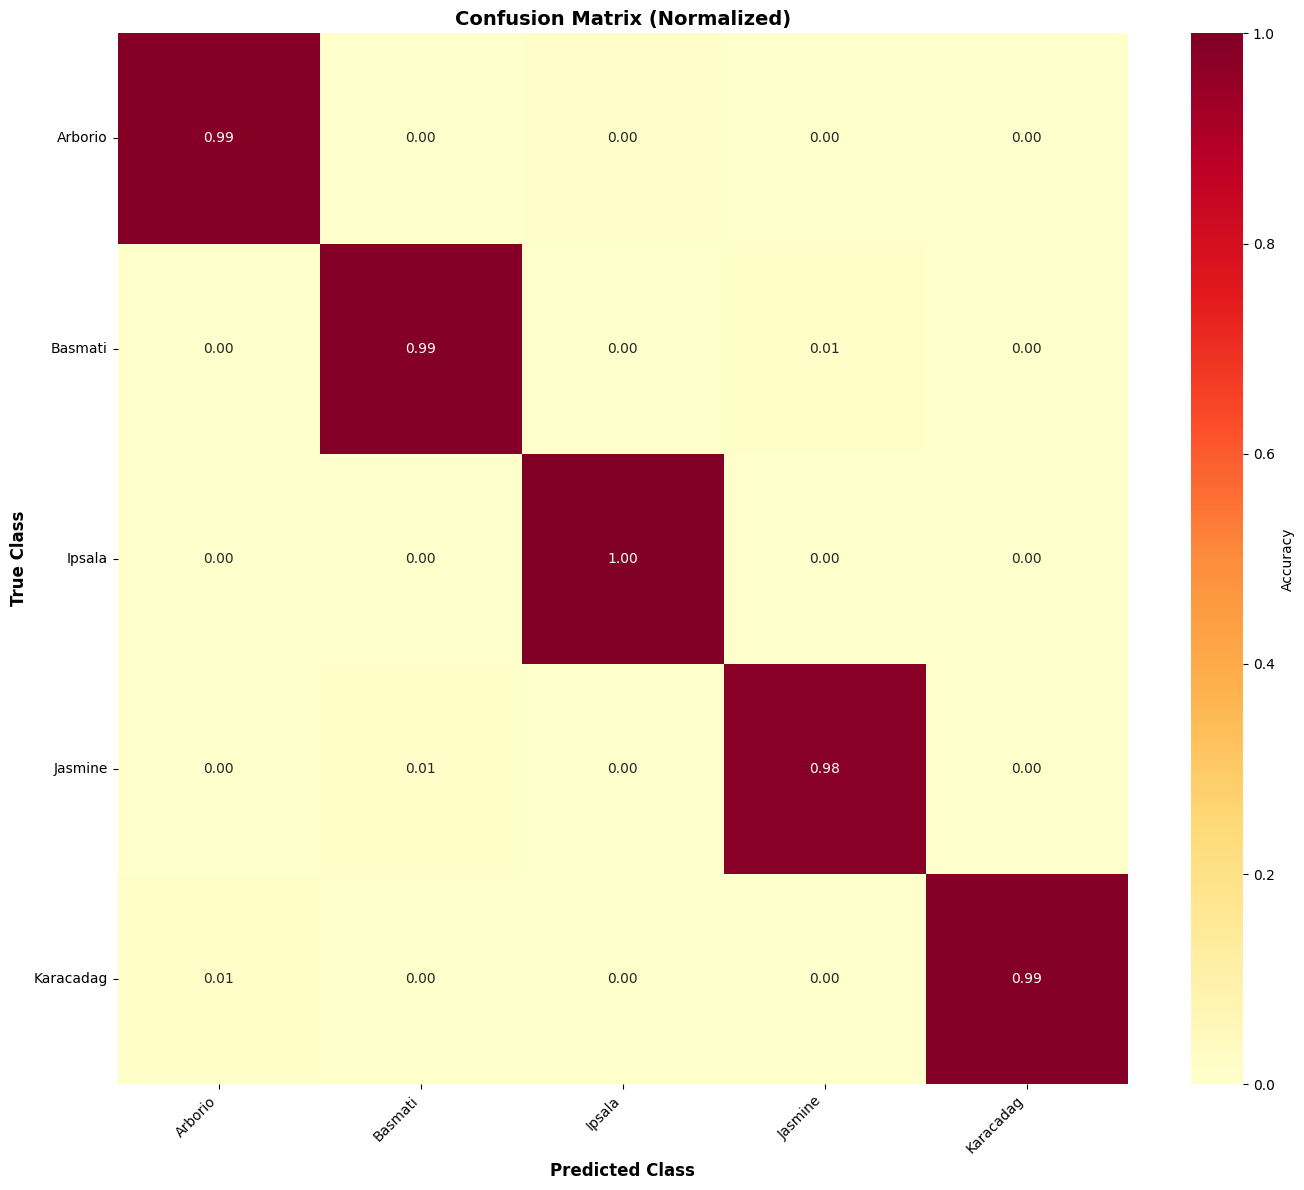

In [ ]:
cm = confusion_matrix(final_labels, final_preds)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(14, 12))
sns.heatmap(
    cm_normalized,
    annot=True,
    fmt='.2f',
    cmap='YlOrRd',
    xticklabels=class_names,
    yticklabels=class_names,
    cbar_kws={'label': 'Accuracy'},
    vmin=0,
    vmax=1
)

plt.xlabel('Predicted Class', fontsize=12, fontweight='bold')
plt.ylabel('True Class', fontsize=12, fontweight='bold')
plt.title('Confusion Matrix (Normalized)', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

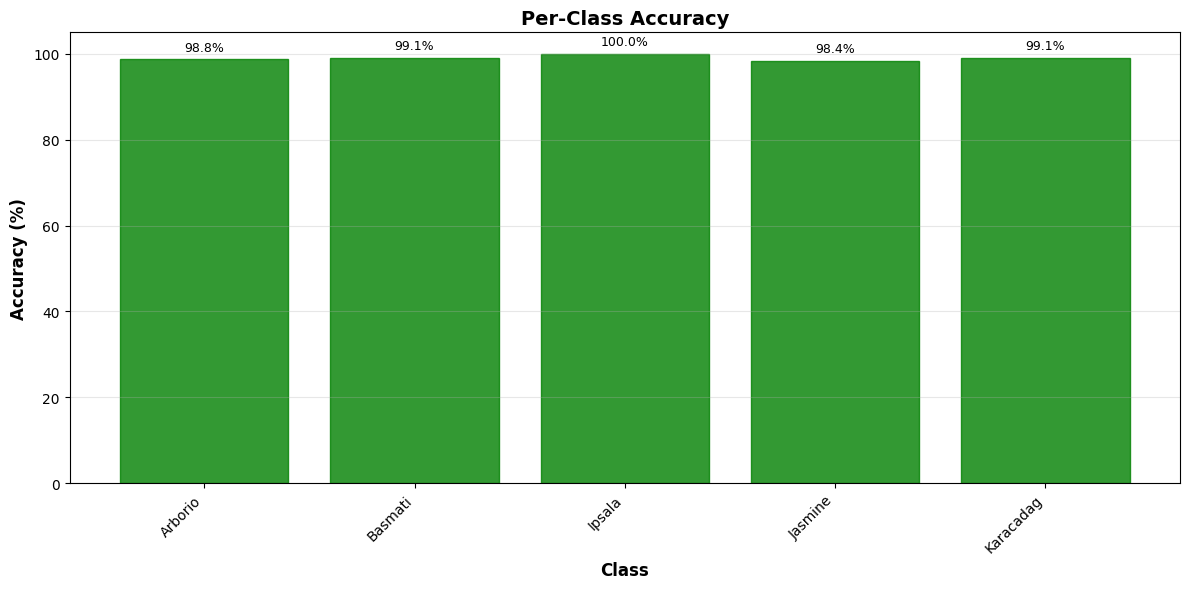

In [ ]:
classes = list(per_class_acc.keys())
accuracies = list(per_class_acc.values())

plt.figure(figsize=(12, 6))
bars = plt.bar(range(len(classes)), accuracies, color='steelblue', alpha=0.8)

for bar, acc in zip(bars, accuracies):
    if acc >= 90:
        bar.set_color('green')
    elif acc >= 70:
        bar.set_color('orange')
    else:
        bar.set_color('red')

plt.xlabel('Class', fontsize=12, fontweight='bold')
plt.ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
plt.title('Per-Class Accuracy', fontsize=14, fontweight='bold')
plt.xticks(range(len(classes)), classes, rotation=45, ha='right')
plt.ylim(0, 105)
plt.grid(axis='y', alpha=0.3)

for i, acc in enumerate(accuracies):
    plt.text(i, acc + 2, f'{acc:.1f}%', ha='center', fontsize=9)

plt.tight_layout()
plt.savefig('per_class_accuracy.png', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
print(f"\n✓ Best Validation Accuracy: {best_val_acc:.2f}%")
print(f"✓ Model saved as 'best_seed_model.pth'")
print(f"\n📥 Download files from left sidebar (Files icon)")


✓ Best Validation Accuracy: 99.07%
✓ Model saved as 'best_seed_model.pth'

📥 Download files from left sidebar (Files icon)


In [ ]:
from google.colab import files

uploaded = files.upload()

Saving Reis_Arborio.jpg to Reis_Arborio.jpg


In [ ]:
def predict_image(model: nn.Module, image_path: str, class_names: List[str]) -> Dict[str, Any]:
    from PIL import Image

    transform = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    img = Image.open(image_path).convert('RGB')
    img_tensor = transform(img).unsqueeze(0).to(DEVICE)

    model.eval()
    with torch.no_grad():
        output = model(img_tensor)
        probabilities = torch.softmax(output, dim=1)
        confidence, predicted = torch.max(probabilities, 1)

    pred_class = predicted.item()
    conf_score = confidence.item()

    top5_prob, top5_idx = torch.topk(probabilities, k=min(5, len(class_names)), dim=1)

    result = {
        'predicted_class': class_names[pred_class],
        'confidence': conf_score,
        'top5': [(class_names[top5_idx[0][i].item()], top5_prob[0][i].item()) for i in range(top5_prob.size(1))]
    }

    return result

for filename in uploaded.keys():
    result = predict_image(model, filename, class_names)
    print(f"\nImage: {filename}")
    print(f"Predicted: {result['predicted_class']} ({result['confidence']*100:.2f}%)")
    print(f"Top 5:")
    for cls, prob in result['top5']:
        print(f"  {cls}: {prob*100:.2f}%")